<a href="https://colab.research.google.com/github/biniyam-mulugeta/test_co_2/blob/main/google_resnet_120_v5_for_CML_KNN_final01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
import numpy as np 
import keras
from keras.models import Model
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,DepthwiseConv2D,Add#,Dense,Dropout,Conv2D
from keras.applications import densenet,mobilenet, mobilenet_v2,efficientnet#densenetmobilenet_v2#,efficientnet,vgg16,densenet
from keras.applications import vgg19,resnet
#from keras_preprocessing import image
#from keras_preprocessing.image import ImageDataGenerator
#from keras.utils.all_utils import to_categorical
from sklearn import preprocessing
from skimage.filters import threshold_otsu
import cv2
from pathlib import Path
import os
import glob
import matplotlib.pyplot as plt
#import seaborn as sns
#import zipfile
%matplotlib inline

In [3]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score,GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import classification_report,f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from skimage import io

In [4]:
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,Input,Dense,Dropout,Conv2D,Activation,MaxPooling2D,BatchNormalization
from keras.layers import MaxPool2D,AveragePooling2D

In [5]:
import pandas as pd

In [6]:
SIZE = 32
data_image = []
data_label = []
for dir_path in glob.glob("/content/drive/My Drive/coffee_dataset/*"):
    label = dir_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        print(img_path)
        img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(SIZE,SIZE))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        
        img = cv2.GaussianBlur(img,(5,5),0)
  
        #img = otsu_segmentation(img)]

        data_image.append(img)
        data_label.append(label)
data_image = np.array(data_image)
data_label = np.array(data_label)

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/coffee_dataset/rust_cro/1424_1.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1424_2.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1425.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1425_1.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1425_2.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1427.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1427_1.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1429.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1430.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1430_1.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1431.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1431_1.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1434.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1434_1.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1436.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1436_1.jpg
/content/drive/My D

In [7]:
le = preprocessing.LabelEncoder()
le.fit(data_label)
train_labe_encoded = le.transform(data_label)

In [8]:
x_train,y_train = data_image,train_labe_encoded
x_train = x_train/255.0

### train test validate splite

In [9]:
from sklearn.model_selection import train_test_split

In [38]:
x_tr,x_te,y_tr,y_te = train_test_split(x_train,train_labe_encoded,test_size=0.40,shuffle=True,random_state=42,stratify=train_labe_encoded)

In [39]:

print(x_tr.shape,'----',y_tr.shape)
print(x_te.shape,'----',y_te.shape)

(3708, 32, 32, 3) ---- (3708,)
(2472, 32, 32, 3) ---- (2472,)


In [40]:
#x_v,x_tes,y_v,y_tes = train_test_split(x_te,y_te,test_size=0.5,shuffle=True,random_state=42,stratify=y_te)

### GoogleNet

In [13]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [14]:
kernel_init = keras.initializers.he_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [15]:
input_layer = Input(shape=(32, 32, 3))

x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((2, 2), padding='same', strides=(1, 1), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(2, 2), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')


x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(7, activation='softmax', name='output')(x)
google_net = Model(input_layer,x, name='inception_v1')

### ResNet

In [16]:
from keras.layers import add
stride = 1
CHANNEL_AXIS = 3

def res_layer(x ,filters,pooling = False,dropout = 0.0):
    temp = x
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)
    temp = BatchNormalization(axis = CHANNEL_AXIS)(temp)
    temp = Activation("relu")(temp)
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)

    x = add([temp,Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(x)])
    if pooling:
        x = MaxPooling2D((2,2))(x)
    if dropout != 0.0:
        x = Dropout(dropout)(x)
    x = BatchNormalization(axis = CHANNEL_AXIS)(x)
    x = Activation("relu")(x)
    return x

In [17]:
inp = Input(shape = (32,32,3))
x = inp
x = Conv2D(16,(3,3),strides = stride,padding = "same")(x)
x = BatchNormalization(axis = CHANNEL_AXIS)(x)
x = Activation("relu")(x)
x = res_layer(x,32,dropout = 0.2)
x = res_layer(x,32,dropout = 0.3)
x = res_layer(x,32,dropout = 0.4,pooling = True)
x = res_layer(x,64,dropout = 0.2)
#x = res_layer(x,64,dropout = 0.2,pooling = True)
#x = res_layer(x,256,dropout = 0.4)
x = GlobalAveragePooling2D()(x)
#x = Dropout(0.4)(x)
#x = Dense(4096,activation = "relu")(x)
x = Dropout(0.23)(x)
x = Dense(7,activation = "softmax")(x)

resnet_model = Model(inp,x,name = "Resnet")

### proposed model

In [18]:
out1 = google_net.get_layer(index = -3).output
out2 = resnet_model.get_layer(index= -3).output
out = concatenate([out1,out2])

out = Dense(64,activation='relu')(out)
out = Dropout(0.35)(out)
out = Dense(128,activation='relu')(out)
out = Dropout(0.40)(out)
#out = Dense(256,activation='relu')(out)
#out = Dropout(0.50)(out)


output = Dense(7,activation='softmax')(out)

In [19]:
e_model = Model(inputs = [google_net.input,resnet_model.input],outputs = output)

In [41]:
print("Feature extraction ...")
prediction_tr = np.array(e_model.predict([x_tr,x_tr]))
prediction_tr.shape

Feature extraction ...


(3708, 7)

In [42]:
Xtrain = np.reshape(prediction_tr, (prediction_tr.shape[0], prediction_tr.shape[1]))

In [43]:
prediction_tes = np.array(e_model.predict([x_te,x_te]))

In [44]:
Xtest = np.reshape(prediction_tes, (prediction_tes.shape[0], prediction_tes.shape[1]))

In [45]:
print('\tFeatures training shape: ', Xtrain.shape)
print('\tFeatures testing shape: ', Xtest.shape)

	Features training shape:  (3708, 7)
	Features testing shape:  (2472, 7)


### ROC for KNN

In [46]:
knn = KNeighborsClassifier()

In [47]:
error_rate = []
for i in range(1,16):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(Xtrain,y_tr)
 pred_i = knn.predict(Xtest)
 error_rate.append(np.mean(pred_i != y_te))

Minimum error:- 0.25849514563106796 at K = 7


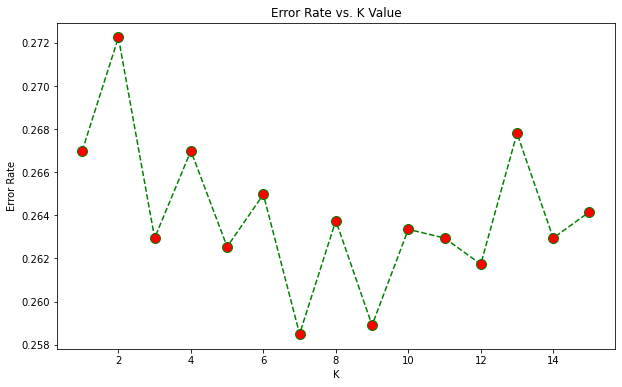

In [48]:
plt.figure(figsize=(10,6))
plt.plot(range(1,16),error_rate,color='green', linestyle='dashed',marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
req_k_value = error_rate.index(min(error_rate))+1
print("Minimum error:-",min(error_rate),"at K =",req_k_value)

In [49]:
k_range = list(range(1, 20))
param_grid = dict(n_neighbors=k_range)

In [50]:
CV_knn = grid = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy', return_train_score=False,verbose=1)
CV_knn.fit(Xtrain, y_tr)

Fitting 3 folds for each of 19 candidates, totalling 57 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_neighbors=15),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy', verbose=1)

In [51]:
print(CV_knn.best_params_,CV_knn.best_score_)

{'n_neighbors': 8} 0.7324703344120821


In [52]:
df = pd.DataFrame(CV_knn.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002217,0.000081,0.031594,0.002694,1,{'n_neighbors': 1},0.717638,0.733819,0.724919,0.725458,0.006617,13
1,0.002166,0.000046,0.032564,0.003017,2,{'n_neighbors': 2},0.707929,0.716828,0.703074,0.709277,0.005695,19
2,0.002231,0.000169,0.031712,0.002182,3,{'n_neighbors': 3},0.726537,0.728155,0.720874,0.725189,0.003122,15
3,0.002152,0.000123,0.035314,0.004173,4,{'n_neighbors': 4},0.723301,0.732201,0.722492,0.725998,0.004398,10
4,0.002142,0.000039,0.032050,0.000885,5,{'n_neighbors': 5},0.721683,0.726537,0.724919,0.724380,0.002018,17
5,0.002290,0.000111,0.031729,0.000655,6,{'n_neighbors': 6},0.714401,0.728155,0.731392,0.724649,0.007366,16
6,0.002166,0.000022,0.032891,0.001153,7,{'n_neighbors': 7},0.722492,0.729773,0.733819,0.728695,0.004687,7
7,0.003093,0.001201,0.033078,0.001380,8,{'n_neighbors': 8},0.732201,0.735437,0.729773,0.732470,0.002320,1
8,0.002303,0.000101,0.037824,0.008184,9,{'n_neighbors': 9},0.722492,0.733010,0.734628,0.730043,0.005380,5
9,0.002271,0.000126,0.033090,0.000324,10,{'n_neighbors': 10},0.724110,0.737864,0.728964,0.730313,0.005695,4


In [53]:
df = pd.DataFrame(CV_knn.cv_results_)
mask = df['rank_test_score']<10
newdf = df[mask]
newdf[['param_n_neighbors','params','mean_test_score','rank_test_score']]

,param_n_neighbors,params,mean_test_score,rank_test_score
6,7,{'n_neighbors': 7},0.728695,7
7,8,{'n_neighbors': 8},0.732470,1
8,9,{'n_neighbors': 9},0.730043,5
9,10,{'n_neighbors': 10},0.730313,4
10,11,{'n_neighbors': 11},0.730852,2
11,12,{'n_neighbors': 12},0.730852,2
14,15,{'n_neighbors': 15},0.727077,8
15,16,{'n_neighbors': 16},0.729234,6
18,19,{'n_neighbors': 19},0.726537,9


In [54]:
#skfolds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)
skfolds = KFold(n_splits=3)

In [55]:
knn=KNeighborsClassifier(n_neighbors=7)
score = []
i = 0
for trainset,testset in skfolds.split(Xtrain,y_tr):
    predicted_targets = np.array([])
    actual_targets = np.array([])
    accuracy_list = list()
    predicted_train_targets = np.array([])
    actual_train_targets = np.array([])
    accuracy_train_list = list()
    print("folds ", i)
    print(trainset,"having :" , len(trainset))
    print(testset,"having :" , len(testset))

    x_tr,x_te=Xtrain[trainset],Xtrain[testset]
    y_trin,y_test=y_tr[trainset],y_tr[testset]

    #clone_clf = clone(svm)
    knn.fit(x_tr, y_trin)
    predicted_labels = knn.predict(x_te)
    accuracy = accuracy_score(y_test, predicted_labels)
    
    predicted_t_labels = knn.predict(x_tr)
    accuracy_t = accuracy_score(y_trin, predicted_t_labels)
    
    predicted_targets = np.append(predicted_targets, predicted_labels)
    actual_targets = np.append(actual_targets, y_test)
    accuracy_list.append(accuracy)
    
    predicted_train_targets = np.append(predicted_train_targets, predicted_t_labels)
    actual_train_targets = np.append(actual_train_targets, y_trin)
    accuracy_train_list.append(accuracy_t)
    
    print("iteration", i)
    i+=1

folds  0
[1236 1237 1238 ... 3705 3706 3707] having : 2472
[   0    1    2 ... 1233 1234 1235] having : 1236
iteration 0
folds  1
[   0    1    2 ... 3705 3706 3707] having : 2472
[1236 1237 1238 ... 2469 2470 2471] having : 1236
iteration 1
folds  2
[   0    1    2 ... 2469 2470 2471] having : 2472
[2472 2473 2474 ... 3705 3706 3707] having : 1236
iteration 2


In [56]:
labeles = ['CBD','CB_Healthy','Leaf Healthy','Cercospora','Mold','Phoma','CLR']

	Validation Accuracy of KNN: 0.7330


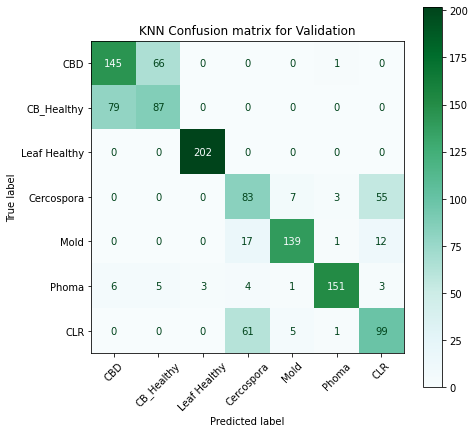

In [57]:
    fig,ax = plt.subplots(figsize=(7,7))
    acc = accuracy_score(predicted_labels, np.ravel(y_test, order='C'))
    print("\tValidation Accuracy of KNN: %0.4f" % acc)
    cm = confusion_matrix(actual_targets, predicted_targets, labels=knn.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("KNN Confusion matrix for Validation")
    plt.show()

	Training Accuracy of KNN: 0.8038


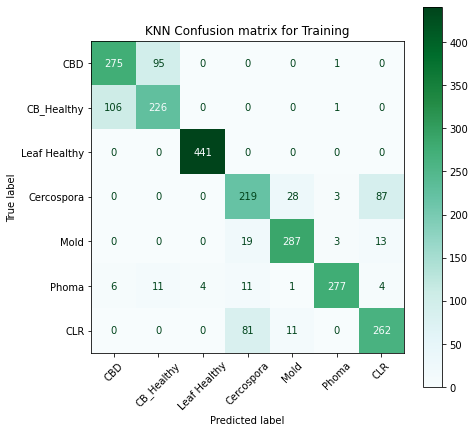

In [58]:
    fig,ax = plt.subplots(figsize=(7,7))
    acc = accuracy_score(predicted_t_labels, np.ravel(y_trin, order='C'))
    print("\tTraining Accuracy of KNN: %0.4f" % acc)
    cm = confusion_matrix(actual_train_targets, predicted_train_targets, labels=knn.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("KNN Confusion matrix for Training")
    plt.show()

In [59]:
result = knn.predict(Xtest)

acc = accuracy_score(result, np.ravel(y_te, order='C'))
print("\tTesting Accuracy of KNN: %0.4f" % acc)
print(classification_report(y_te,result))

	Testing Accuracy of KNN: 0.7282
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       389
           1       0.52      0.57      0.54       333
           2       0.99      1.00      1.00       428
           3       0.54      0.57      0.56       324
           4       0.89      0.85      0.87       327
           5       0.95      0.83      0.88       324
           6       0.62      0.63      0.62       347

    accuracy                           0.73      2472
   macro avg       0.73      0.72      0.72      2472
weighted avg       0.74      0.73      0.73      2472



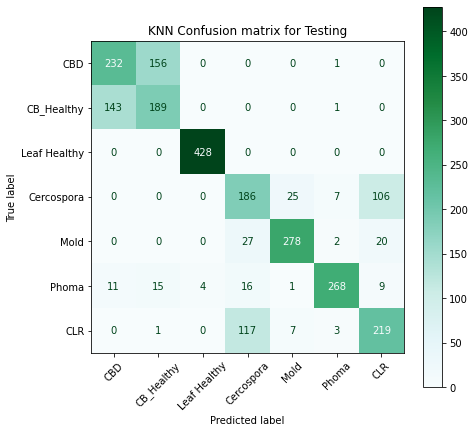

In [60]:
    fig,ax = plt.subplots(figsize=(7,7))
    cm = confusion_matrix(y_te, result, labels=knn.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("KNN Confusion matrix for Testing")
    plt.show()

In [61]:
from yellowbrick.classifier import ROCAUC,ConfusionMatrix

In [62]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0:'cbd',1: 'cb_healthy',2: 'leaf healthy' ,3: 'Cercospora', 4: 'mold', 5: 'phoma',6 : 'rust'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

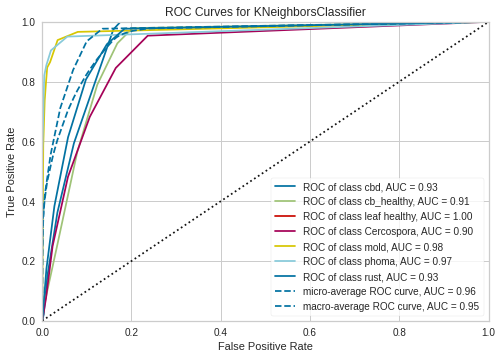

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f74a2394490>,
       encoder={0: 'cbd', 1: 'cb_healthy', 2: 'leaf healthy', 3: 'Cercospora',
                4: 'mold', 5: 'phoma', 6: 'rust'},
       estimator=KNeighborsClassifier(n_neighbors=7))

In [63]:
plot_ROC_curve(knn,Xtrain,y_tr,Xtest,y_te)